In [ ]:
%load_ext autoreload
%autoreload 2
# from src.vnc import run_vnc_simulation


import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from pathlib import Path
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
import jax
# jax.config.update("jax_enable_x64", True)
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Use GPU 0
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
import sparse

from src.optimized_vnc import *
from src.plot_utils import *


In [2]:
experiment='Stim_Neurons'
with initialize(version_base=None, config_path="../configs"):
    cfg=compose(config_name='config.yaml', overrides= [f"experiment={experiment}", "paths=glados", "version=debug", f'run_id=Testing'],return_hydra_config=True,)
    HydraConfig.instance().set_config(cfg)

for k in cfg.paths.keys():
    if (k != 'user'):
        cfg.paths[k] = Path(cfg.paths[k])
        cfg.paths[k].mkdir(parents=True, exist_ok=True)




# experiment='default'
# with initialize(version_base=None, config_path="../configs"):
#     cfg_old=compose(config_name='config.yaml', overrides= [f"experiment={experiment}", "paths=glados", "version=debug", f'run_id=Testing'],return_hydra_config=True,)
#     HydraConfig.instance().set_config(cfg_old)

# for k in cfg_old.paths.keys():
#     if (k != 'user'):
#         cfg_old.paths[k] = Path(cfg_old.paths[k])
#         cfg_old.paths[k].mkdir(parents=True, exist_ok=True)


In [3]:
# results = run_vnc_simulation_optimized(cfg)
# save_path = cfg.paths.ckpt_dir  / "bdn2.npz"

results = sparse.load_npz(cfg.paths.ckpt_dir  / "bdn2.npz").todense().astype(np.float32)

In [23]:
params, config = load_vnc_net(cfg)
simulator = OptimizedSimulator(params, config)


Pre-compiling JAX functions...
Compilation complete.


In [24]:
additional_param = jnp.array([0] * simulator.n_param_sets)
# Create expanded parameter arrays for all stimulus combinations
expanded_params = simulator._create_expanded_params(additional_param)

In [25]:
n_batches = 1
batch_size = 100
all_results = []
total_processed = 0

for batch_idx in range(n_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, simulator.total_combinations)
    actual_batch_size = end_idx - start_idx
    
    # Extract batch data
    batch_data = simulator._extract_batch_data_multi_stim(start_idx, end_idx, expanded_params)

In [4]:
params, config = load_vnc_net(cfg)

In [6]:
"""Load and configure VNC network parameters and simulation settings."""
validate_config(cfg)

W, W_table = load_connectivity(cfg)
sim_config = create_sim_config(cfg, W)



# stim_neurons = jnp.array(cfg.experiment.stimNeurons, dtype=jnp.int32)

newkey, subkey = jax.random.split(sim_config.rng_key)
newkey = jax.random.split(newkey, sim_config.num_sims)
tau, a, threshold, fr_cap = sample_neuron_parameters(cfg, sim_config.n_neurons, sim_config.num_sims, subkey)

if "size" in W_table:
    a, threshold = set_sizes(W_table["size"].values, a, threshold)
else:
    a, threshold = set_sizes(W_table["surf_area_um2"].values, a, threshold)

input_currents = jnp.stack([make_input(sim_config.n_neurons, jnp.array(stim_neurons, dtype=jnp.int32), sim_config.stim_input) for stim_neurons in cfg.experiment.stimNeurons], axis=0)
exc_dn_idxs, inh_dn_idxs, exc_in_idxs, inh_in_idxs, mn_idxs = extract_shuffle_indices(W_table)

params = NeuronConfig(
    W=W, W_table=W_table, tau=tau, a=a, threshold=threshold, fr_cap=fr_cap,
    input_currents=input_currents, seeds=newkey, stim_neurons=cfg.experiment.stimNeurons,
    exc_dn_idxs=exc_dn_idxs, inh_dn_idxs=inh_dn_idxs, exc_in_idxs=exc_in_idxs,
    inh_in_idxs=inh_in_idxs, mn_idxs=mn_idxs,
)

In [8]:
input_currents.shape, threshold.shape

((2, 4561), (200, 4561))

In [ ]:
W, W_table = load_connectivity(cfg)
# CHANGE DEFAULTS
allExcDNs = W_table.loc[(W_table["class"] == "descending neuron") & (W_table["predictedNt"] == "acetylcholine")]
stimNeurons = allExcDNs.index.to_list()
stimNeurons = [[neuron] for neuron in stimNeurons]
nSims = len(stimNeurons)

In [ ]:
params, config = load_vnc_net(cfg)

In [ ]:
n_devices = jax.device_count()
n_samples = len(params.tau)
additional_param = jnp.array([0] * n_samples)
batch_size=250
device_batches = create_device_specific_batches(params, additional_param, batch_size, n_devices)

In [ ]:
from src.Archive.vnc_old import load_vnc_net as load_vnc_net_old
params, config = load_vnc_net(cfg)
params_old, config_old = load_vnc_net_old(cfg_old)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()
for n, (orig,new) in enumerate(zip([params_old.tau,params_old.threshold,params_old.a,params_old.fr_cap], [params.tau, params.threshold, params.a, params.fr_cap])):
    axs[n].hist(orig.flatten(), bins=50, alpha=0.5, label='Sampled', density=True)
    axs[n].hist(new.flatten(), bins=50, alpha=0.5, label='Original', density=True)
    axs[n].set_title(f"Histogram of {n}")
    axs[n].set_xlabel(n)
    axs[n].set_ylabel("Frequency")

In [ ]:
results = run_vnc_simulation(cfg)

In [4]:
np.where(np.all(np.sum(results,axis=-1)==0,axis=-1))

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]))

In [17]:
results.shape

(2, 50, 4561, 2000)

0.103227355


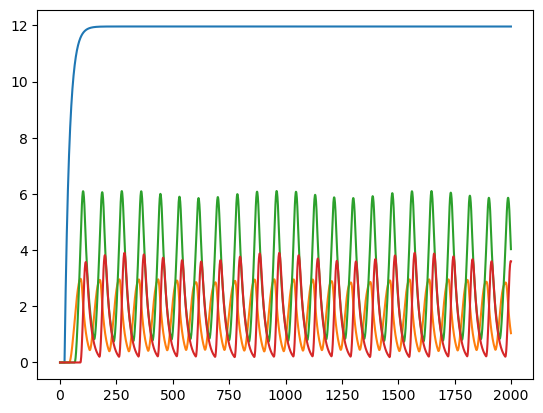

In [7]:
R = results[0][30]


wTable = pd.read_csv("../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
nonMns = wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)]
mnIdxs = wTable.loc[wTable["class"]=="motor neuron"].index


for i in nonMns.index:
# for i in mnIdxs:
    plt.plot(R[i])
    #plt.plot(Rtsp[i])

print(np.mean(R))


In [ ]:
from scipy import signal
import numpy as np
def neuron_oscillation_score_helper(activity,prominence):
    activity = activity-np.min(activity)
    activity = 2 * activity/np.max(activity) - 1

    autocorr = np.correlate(activity,activity,mode="full") / np.inner(activity,activity)
    lags = signal.correlation_lags(len(activity),len(activity))
    autocorr = autocorr[lags>0]
    lags = lags[lags>0]

    peaks, peakProperties = signal.find_peaks(autocorr,height=(None,None),prominence=prominence)
    if len(peaks) > 0:
        score = np.min([np.max(peakProperties["peak_heights"]),np.max(peakProperties["prominences"])])
        frequency = 1 / peaks[np.argmax(peakProperties["prominences"])]
    else:
        score = 0
        frequency = 0

    return score, frequency

def neuron_oscillation_score(activity,returnFrequency=False,prominence=0.05):
    rawScore, frequency = neuron_oscillation_score_helper(activity,prominence)
    # normalize to sine wave of the same frequency and duration
    if rawScore == 0:
        score = 0
    else:
        refSinScore, _ = neuron_oscillation_score_helper(np.sin(2*np.pi*frequency*np.arange(len(activity))),prominence)
        refCosScore, _ = neuron_oscillation_score_helper(np.cos(2*np.pi*frequency*np.arange(len(activity))),prominence)
        refScore = np.max((refSinScore,refCosScore))
        score = rawScore / refScore

    if returnFrequency:
        return score, frequency
    else:
        return score

def sim_oscillation_score(R,activeMnIdxs,start=None,end=None,returnFrequency=False):
    """calculate oscillation score for a simulation"""
    if start is None:
        start = 0
    if end is None:
        end = -1

    if returnFrequency:
        neuronOscillationScores = []
        frequencies = []

        for j in activeMnIdxs:
            score, freq = neuron_oscillation_score(R[j][start:end],returnFrequency=True)
            neuronOscillationScores.append(score)
            frequencies.append(freq)

        return np.mean(neuronOscillationScores), np.nanmean(frequencies)
        
    else:
        neuronOscillationScores = [neuron_oscillation_score(R[j][start:end]) for j in activeMnIdxs] # scores for each neuron
        return np.mean(neuronOscillationScores) # average for the simulation
    
    

def run_with_stim_adjustment(self,maxIters=10,clampedNeurons=[],clampedRates=None,nActiveUpper=500,nActiveLower=5,nHighFrUpper=100):
    nextHighest = None
    nextLowest = None

    for i in range(maxIters):
        self.run(clampedNeurons=clampedNeurons,clampedRates=clampedRates)
        R = self.R

        nActive = sum(np.sum(R,1)>0)
        nHighFr = sum(np.max(R,1)>100)

        currInputs = self.inputs.copy()

        print(f"Run {i}")
        print(f"max stimI = {np.max(currInputs)}")
        print(f"nActive: {nActive}")
        print(f"nHighFr: {nHighFr}")

        if (nActive > nActiveUpper) or (nHighFr > nHighFrUpper): # too strong
            if nextLowest is None:
                newInputs = currInputs/2
            else:
                newInputs = (currInputs+nextLowest)/2
            nextHighest = currInputs
        elif (nActive < nActiveLower): # too weak
            if nextHighest is None:
                newInputs = currInputs*2
            else:
                newInputs = (currInputs+nextHighest)/2
            nextLowest = currInputs
        else:
            break

        self.set_input(newInputs)